In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import nn

In [537]:
df = pd.read_csv("concertriccir2.csv")

In [538]:
df.head()

,7.003345706103683010e-01,-2.470675778972781789e-01,0.000000000000000000e+00
0,-3.950019,2.740080,1.0
1,0.150222,-2.157638,1.0
2,-1.672050,-0.941519,1.0
3,2.560483,-1.846577,1.0
4,-1.724979,3.463930,1.0


In [539]:
df.rename(columns={"7.003345706103683010e-01" : "A", "-2.470675778972781789e-01" : "B", "0.000000000000000000e+00" : "C"}, inplace=True)

In [540]:
df.head()

,A,B,C
0,-3.950019,2.740080,1.0
1,0.150222,-2.157638,1.0
2,-1.672050,-0.941519,1.0
3,2.560483,-1.846577,1.0
4,-1.724979,3.463930,1.0


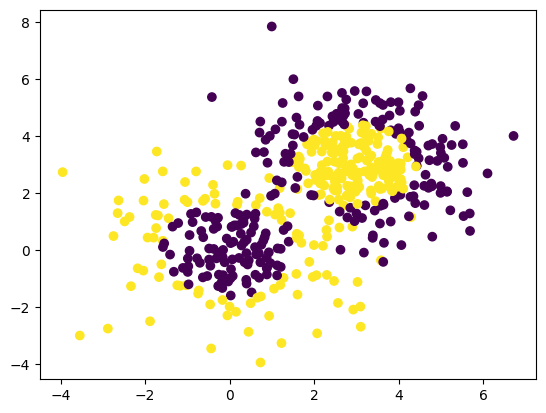

In [541]:
plt.scatter(df["A"], df["B"], c= df["C"])
plt.show()

In [542]:
X = df.iloc[:,0:2].values
y = df.iloc[:,-1].values

In [543]:
# convert data to tensors
X_ten = torch.from_numpy(X).type(torch.float)
y_ten = torch.from_numpy(y).type(torch.float)

In [544]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [545]:
class without_batch_norm(nn.Module):
    def __init__(self, num_inputs=2, num_class=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(num_inputs, 2),
            nn.ReLU(),
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, num_class),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)
model = without_batch_norm().to(device)

In [546]:
model

without_batch_norm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [547]:
X_ten.shape

torch.Size([499, 2])

In [548]:
from torchinfo import summary

In [549]:
model_summary = summary(model = model, input_size=X_ten.shape)
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
without_batch_norm                       [499, 1]                  --
├─Sequential: 1-1                        [499, 1]                  --
│    └─Linear: 2-1                       [499, 2]                  6
│    └─ReLU: 2-2                         [499, 2]                  --
│    └─Linear: 2-3                       [499, 2]                  6
│    └─ReLU: 2-4                         [499, 2]                  --
│    └─Linear: 2-5                       [499, 1]                  3
│    └─Sigmoid: 2-6                      [499, 1]                  --
Total params: 15
Trainable params: 15
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [550]:
model_summary1 = summary(model = model, input_size=(499,2), col_names=("output_size", "num_params"))
model_summary1

Layer (type:depth-idx)                   Output Shape              Param #
without_batch_norm                       [499, 1]                  --
├─Sequential: 1-1                        [499, 1]                  --
│    └─Linear: 2-1                       [499, 2]                  6
│    └─ReLU: 2-2                         [499, 2]                  --
│    └─Linear: 2-3                       [499, 2]                  6
│    └─ReLU: 2-4                         [499, 2]                  --
│    └─Linear: 2-5                       [499, 1]                  3
│    └─Sigmoid: 2-6                      [499, 1]                  --
Total params: 15
Trainable params: 15
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [551]:
X_ten.shape

torch.Size([499, 2])

In [552]:
# loss_fc and optimizer
loss_fc = nn.BCELoss() 

optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.001)

In [553]:
# building a training and evaluation loop

epochs = 500

train_loss_values1 = []
test_loss_values1 = []
epoch_count1 = []
accuracy1 = []

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X_ten).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y_ten)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X_ten).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y_ten)

    predicted = model.forward(X_ten)
    predicted = (predicted > 0.5).float()
    acc = (predicted == y_ten).float().mean()


# lets print out what is happening
    if epoch % 5 == 0:
        epoch_count1.append(epoch)
        train_loss_values1.append(loss.detach().numpy())
        test_loss_values1.append(test_loss.detach().numpy())
        accuracy1.append(acc.item())
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc.item()}")

Epoch: 0 | Loss: 0.7147746682167053 | Accuracy: 0.4989979863166809
Epoch: 5 | Loss: 0.7129932045936584 | Accuracy: 0.4989979863166809
Epoch: 10 | Loss: 0.7113334536552429 | Accuracy: 0.4989979863166809
Epoch: 15 | Loss: 0.7097963690757751 | Accuracy: 0.4989979863166809
Epoch: 20 | Loss: 0.7083805203437805 | Accuracy: 0.4989979863166809
Epoch: 25 | Loss: 0.7070814371109009 | Accuracy: 0.4989979863166809
Epoch: 30 | Loss: 0.7058930397033691 | Accuracy: 0.4989979863166809
Epoch: 35 | Loss: 0.7048076391220093 | Accuracy: 0.4989979863166809
Epoch: 40 | Loss: 0.7038170695304871 | Accuracy: 0.4989979863166809
Epoch: 45 | Loss: 0.7029130458831787 | Accuracy: 0.4989979863166809
Epoch: 50 | Loss: 0.7020872831344604 | Accuracy: 0.4989979863166809
Epoch: 55 | Loss: 0.7013319730758667 | Accuracy: 0.4989979863166809
Epoch: 60 | Loss: 0.7006403803825378 | Accuracy: 0.4989979863166809
Epoch: 65 | Loss: 0.700005829334259 | Accuracy: 0.4989979863166809
Epoch: 70 | Loss: 0.6994227766990662 | Accuracy: 0.

## After batch normalization

In [554]:
class Batch_Norm(nn.Module):
    def __init__(self, num_inputs=2, num_class=1):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(num_inputs, 3),
            nn.BatchNorm1d(num_features=3, affine=False),
            nn.ReLU(),
            nn.Linear(3, 2),
            nn.BatchNorm1d(num_features=2, affine=False),
            nn.ReLU(),
            nn.Linear(2, num_class),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)
        
model1 = Batch_Norm().to(device)

In [555]:
model1

Batch_Norm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=2, bias=True)
    (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [556]:
summary(model1, input_size=X_ten.shape) 

Layer (type:depth-idx)                   Output Shape              Param #
Batch_Norm                               [499, 1]                  --
├─Sequential: 1-1                        [499, 1]                  --
│    └─Linear: 2-1                       [499, 3]                  9
│    └─BatchNorm1d: 2-2                  [499, 3]                  --
│    └─ReLU: 2-3                         [499, 3]                  --
│    └─Linear: 2-4                       [499, 2]                  8
│    └─BatchNorm1d: 2-5                  [499, 2]                  --
│    └─ReLU: 2-6                         [499, 2]                  --
│    └─Linear: 2-7                       [499, 1]                  3
│    └─Sigmoid: 2-8                      [499, 1]                  --
Total params: 20
Trainable params: 20
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [557]:
for name, buffer in model1.named_buffers():
    print(f"{name}: Buffer = {buffer}")

network.1.running_mean: Buffer = tensor([0., 0., 0.])
network.1.running_var: Buffer = tensor([1., 1., 1.])
network.1.num_batches_tracked: Buffer = 0
network.4.running_mean: Buffer = tensor([0., 0.])
network.4.running_var: Buffer = tensor([1., 1.])
network.4.num_batches_tracked: Buffer = 0


In [558]:
# loss_fc and optimizer
loss_fc = nn.BCELoss() 

optimizer = torch.optim.Adam(params = model1.parameters(),
                            lr = 0.001)

In [559]:
# building a training and evaluation loop

epochs = 500

train_loss_values = []
test_loss_values = []
epoch_count = []
accuracy2 = []

for epoch in range(epochs):

  model1.train()

  # forward pass
  y_logits = model1(X_ten).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y_ten)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model1.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model1(X_ten).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y_ten)

    predicted = model.forward(X_ten)
    predicted = (predicted > 0.5).float()
    acc2 = (predicted == y_ten).float().mean()


# lets print out what is happening
    if epoch % 5 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        accuracy2.append(acc2.item())
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc2.item()}")
        # print(f'Accuracy: {accuracy.item()}')

Epoch: 0 | Loss: 0.6831098198890686 | Accuracy: 0.5000542402267456
Epoch: 5 | Loss: 0.6816980242729187 | Accuracy: 0.5000542402267456
Epoch: 10 | Loss: 0.6802771091461182 | Accuracy: 0.5000542402267456
Epoch: 15 | Loss: 0.6788845658302307 | Accuracy: 0.5000542402267456
Epoch: 20 | Loss: 0.6775370836257935 | Accuracy: 0.5000542402267456
Epoch: 25 | Loss: 0.6761975884437561 | Accuracy: 0.5000542402267456
Epoch: 30 | Loss: 0.674878716468811 | Accuracy: 0.5000542402267456
Epoch: 35 | Loss: 0.673619270324707 | Accuracy: 0.5000542402267456
Epoch: 40 | Loss: 0.6724053621292114 | Accuracy: 0.5000542402267456
Epoch: 45 | Loss: 0.6712502837181091 | Accuracy: 0.5000542402267456
Epoch: 50 | Loss: 0.6702029705047607 | Accuracy: 0.5000542402267456
Epoch: 55 | Loss: 0.669238805770874 | Accuracy: 0.5000542402267456
Epoch: 60 | Loss: 0.6683470010757446 | Accuracy: 0.5000542402267456
Epoch: 65 | Loss: 0.6674644351005554 | Accuracy: 0.5000542402267456
Epoch: 70 | Loss: 0.6665890216827393 | Accuracy: 0.50

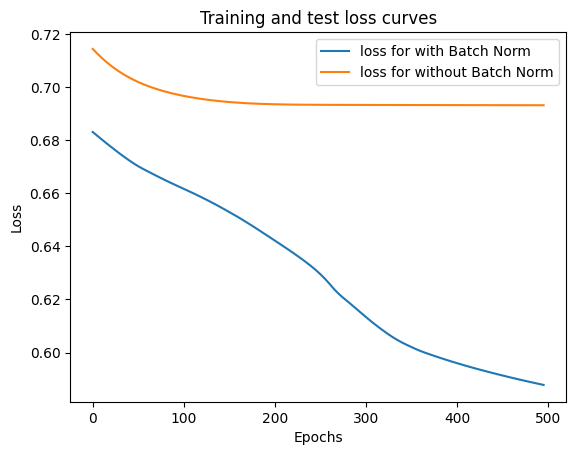

In [560]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="loss for with Batch Norm")
plt.plot(epoch_count1, test_loss_values1, label="loss for without Batch Norm")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

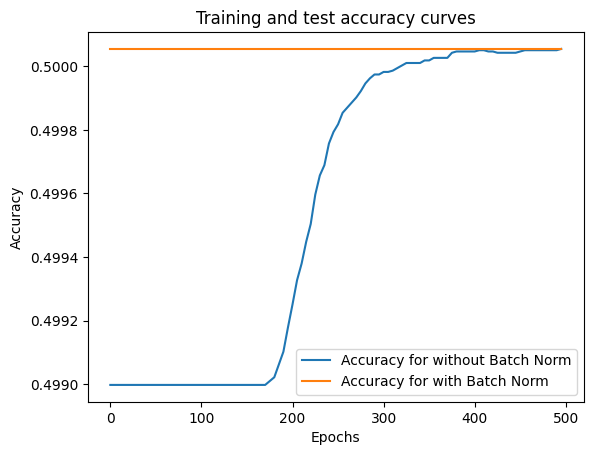

In [561]:
# Plot the loss curves
plt.plot(epoch_count, accuracy1, label="Accuracy for without Batch Norm")
plt.plot(epoch_count1, accuracy2, label="Accuracy for with Batch Norm")
plt.title("Training and test accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()